In [2]:
!pip install SHAP
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time
import warnings
warnings.filterwarnings("ignore")
shap.initjs()
import time
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 13.9 MB/s eta 0:00:00


In [3]:
data = pd.read_csv("diabetes.csv")
data.head()
y = data.iloc[:,-1:]
X = df2 = data.iloc[: , :-1]

x_trn,x_tst = train_test_split(X,test_size=0.2, random_state=0)
y_trn,y_tst = train_test_split(y, test_size=0.2, random_state=0)

x_trn = np.asmatrix(x_trn)
x_tst = np.asmatrix(x_tst)
N = x_trn.shape[0]
N_tst = x_tst.shape[0]

In [5]:
import numpy as np
from tqdm import tqdm


def get_true_KNN(x_trn, x_tst):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn, :] - x_tst[i_tst, :], 2)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
    return x_tst_knn_gt.astype(int)


def compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst, N))
    for j in tqdm(range(N_tst)):
        sp_gt[j, x_tst_knn_gt[j, -1]] = (y_trn[x_tst_knn_gt[j, -1]] == y_tst[j]) / N
        for i in np.arange(N - 2, -1, -1):
            sp_gt[j, x_tst_knn_gt[j, i]] = sp_gt[j, x_tst_knn_gt[j, i + 1]] + \
                                           (int(y_trn[x_tst_knn_gt[j, i]] == y_tst[j]) -
                                            int(y_trn[x_tst_knn_gt[j, i + 1]] == y_tst[j])) / K * min([K, i + 1]) / (
                                                       i + 1)
    return sp_gt

In [7]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('diamonds.csv')
df = pd.get_dummies(df, columns = ['cut', 'color', 'clarity'])
x_trn = df.drop(['price'], axis=1).to_numpy()
y_trn = df['price'].astype(float).to_numpy()
x_trn, y_trn = shuffle(x_trn, y_trn, random_state=10)
x_tst, y_tst = x_trn[:2000], y_trn[:2000]
x_val, y_val = x_trn[2000:5000], y_trn[2000:5000]
x_trn, y_trn = x_trn[5000:9000], y_trn[5000:9000]
K = 1

100%|██████████| 3000/3000 [01:31<00:00, 32.67it/s]


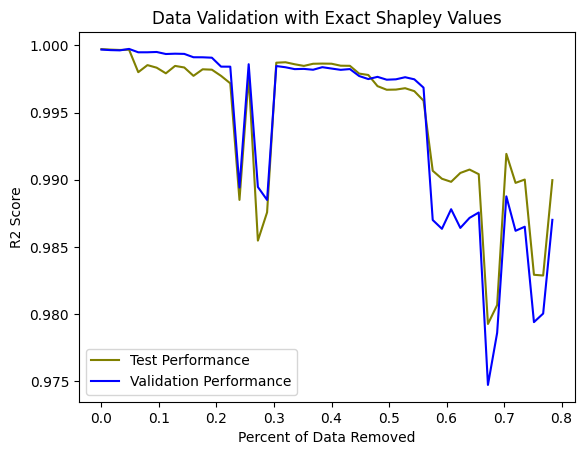

In [8]:
x_val_knn_gt = get_true_KNN(x_trn, x_val)
val_sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_val_knn_gt, y_val, K)
g_values = np.mean(val_sp_gt, axis=0)
count = int(len(x_trn)*4/5)
interval = int(count*0.02)
x = np.arange(0, count, interval)/len(x_trn)
g_r2_scores = []
g_r2_scores_val = []
idxs = np.argsort(g_values)
keep_idxs = idxs.tolist()
for j in range(0, count, interval):
    if len(keep_idxs) == len(x_trn):
        x_train_keep, y_train_keep = x_trn, y_trn
    else:
        x_train_keep, y_train_keep = x_trn[keep_idxs], y_trn[keep_idxs]
    reg = DecisionTreeRegressor()
    reg.fit(x_train_keep, y_train_keep)
    r2_score = reg.score(x_tst, y_tst)
    r2_score_val = reg.score(x_val, y_val)
    g_r2_scores.append(r2_score)
    g_r2_scores_val.append(r2_score_val)
    keep_idxs = keep_idxs[interval:]
plt.plot(x, g_r2_scores, '-', label='Test Performance', color='olive')
plt.plot(x, g_r2_scores_val, '-', label='Validation Performance', color='blue')
plt.ylabel('R2 Score')
plt.xlabel('Percent of Data Removed')
plt.legend(loc="lower left")
plt.title('Data Validation with Exact Shapley Values')
plt.show()

In [9]:
x_tst_knn_gt = get_true_KNN(x_trn, x_tst)

100%|██████████| 2000/2000 [01:16<00:00, 26.10it/s]


In [10]:
sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K)

100%|██████████| 2000/2000 [00:57<00:00, 35.01it/s]


In [11]:
y_axis = sum(sp_gt)
len(y_axis)

4000

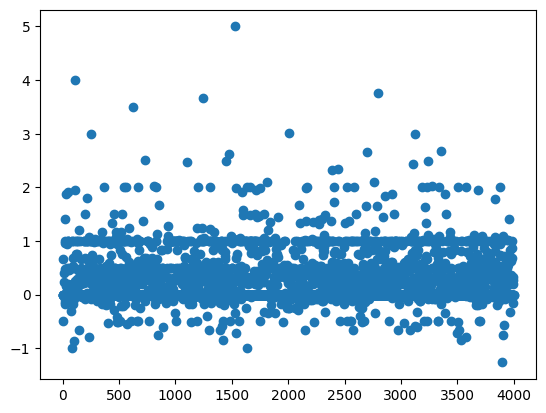

In [16]:
x_axis = range(1,4001)
len(x_axis)
plt.scatter(x_axis, y_axis)

In [1]:
data = pd.read_csv("diabetes.csv")
data.head()
y = data.iloc[:,-1:]
X = df2 = data.iloc[: , :-1]

X_train, X_test = train_test_split(X,test_size=0.2, random_state=0)
y_train,y_test = train_test_split(y, test_size=0.2, random_state=0)

NameError: ignored

In [ ]:
import xgboost

model = xgboost.XGBClassifier().fit(X_train, y_train)

predict = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, predict)
f1

0.6262626262626262

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

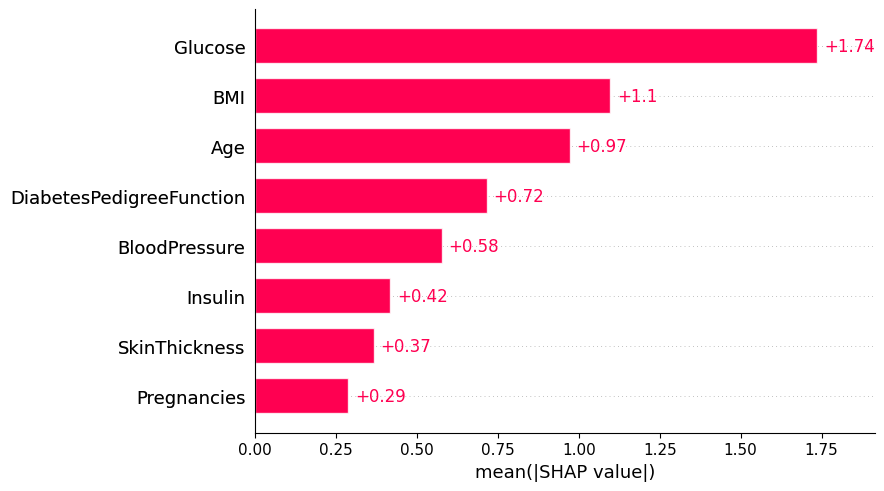

In [ ]:
shap.plots.bar(shap_values)

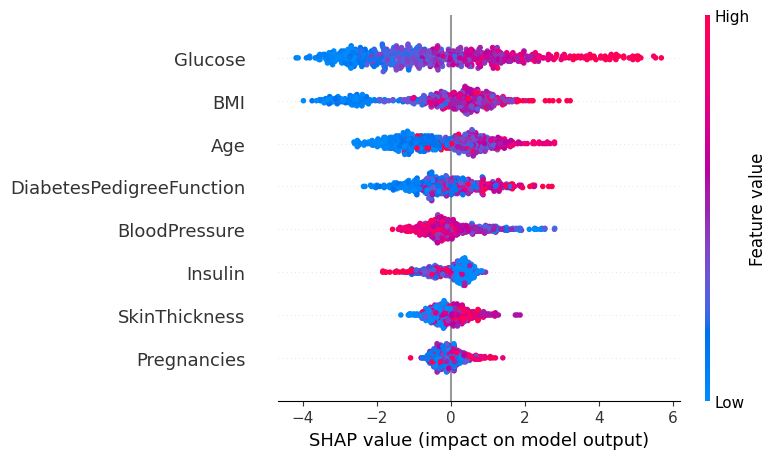

In [ ]:
shap.summary_plot(shap_values, X_train)

In [14]:
import numpy as np

def shapley_value(feature_model, X, y, num_samples=600):
    n_features = X.shape[1]
    shapley_vals = np.zeros(n_features)
    for i in range(n_features):
        # set up a feature mask
        mask = np.zeros(n_features, dtype=bool)
        mask[i] = True
        # compute reference value
        ref_value = feature_model.predict(X)
        # randomly permute feature values
        X_permuted = np.copy(X)
        for j in range(num_samples):
            np.random.shuffle(X_permuted[:, i])
            # compute new prediction with permuted features
            permuted_value = feature_model.predict(X_permuted)
            # compute marginal contribution and add to Shapley value
            marginal_contribution = np.mean(permuted_value - ref_value)
            shapley_vals[i] += marginal_contribution
    # normalize Shapley values
    shapley_vals /= num_samples
    return shapley_vals

In [23]:
data = pd.read_csv("diabetes.csv")
data.head()
y = np.asarray(data.iloc[:50,-1:])
X = df2 = np.asarray(data.iloc[:50 , :-1])

X_train, X_test = train_test_split(X,test_size=0.2, random_state=0)
y_train,y_test = train_test_split(y, test_size=0.2, random_state=0)

from sklearn.linear_model import LogisticRegression

# create a logistic regression model
model = LogisticRegression()

# fit the model to the data
model.fit(X_train, y_train)

# calculate the Shapley values for the model
shapley_vals = shapley_value(model, X_test, y_test)

TypeError: ignored

In [16]:
sum(shapley_vals)

0.073365800865801

In [17]:
import numpy as np
from itertools import permutations
from sklearn.linear_model import LogisticRegression

def shapley_value(X, y):
    n = X.shape[0] # number of data points
    phi = np.zeros(n) # initialize Shapley values to zero
    model = LogisticRegression() # initialize logistic regression model
    for i in range(n):
        # Compute marginal contribution of data point i to all possible coalitions
        mc = np.zeros(n)
        for S in permutations(range(n-1), n-1):
            S = list(S)
            S.insert(i, n-1)
            S = tuple(S)
            X_S = X[list(S)]
            y_S = y[list(S)]
            model.fit(X_S, y_S)
            phi_S = model.score(X_S, y_S)
            mc[i] += (phi_S - phi[list(S[:-1])].sum()/len(S[:-1]))/len(S)
        phi[i] = mc.mean()
    return phi

In [24]:
shapley_values = shapley_value(X, y)

KeyboardInterrupt: ignored

In [13]:
import numpy as np
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier

def shapley_value_knn(X, y, n_neighbors=5, n_iter=1000):
    n = X.shape[0] # number of data points
    phi = np.zeros(n) # initialize Shapley values to zero
    model = KNeighborsClassifier(n_neighbors=n_neighbors) # initialize KNN model
    for _ in range(n_iter):
        S = np.random.choice(n, size=n-1, replace=False)
        S = np.append(S, [n-1])
        X_S = X[S]
        y_S = y[S]
        model.fit(X_S, y_S)
        phi_S = model.score(X_S, y_S)
        for i in range(n):
            if i not in S:
                T = np.append(S, [i])
                X_T = X[T]
                y_T = y[T]
                model.fit(X_T, y_T)
                phi_T = model.score(X_T, y_T)
                mc = phi_S - phi_T
                phi[i] += mc/n_iter
    return phi

In [14]:
asd = shapley_value_knn(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

In [16]:
len(asd)

768

In [22]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

def shapley_knn_mc(X, y, k, X_test, y_test, n_samples=1000):
    n = X.shape[0]
    phi = np.zeros(n)
    clf = KNeighborsClassifier(1)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    for i in range(n):
        phi_temp = 0
        for _ in range(n_samples):
            S = np.random.choice(n, i+1, replace=False)
            X_S = X[S, :]
            y_S = y[S]
            clf.fit(X_S, y_S)
            y_pred_S = clf.predict(X_test)
            acc_S = np.mean(y_pred_S == y_test)
            phi_temp += (acc_S - acc) / n_samples
        phi[i] = phi_temp
    return phi

In [23]:
data = pd.read_csv("diabetes.csv")
data.head()
y = np.asarray(data.iloc[:,-1:])
X = df2 = np.asarray(data.iloc[: , :-1])

X_train, X_test = np.asarray(train_test_split(X,test_size=0.2, random_state=0))
y_train,y_test = np.asarray(train_test_split(y, test_size=0.2, random_state=0))

<ipython-input-23-76506ea4e8d2>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train, X_test = np.asarray(train_test_split(X,test_size=0.2, random_state=0))
<ipython-input-23-76506ea4e8d2>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train,y_test = np.asarray(train_test_split(y, test_size=0.2, random_state=0))


In [24]:
vals = shapley_knn_mc(X_train, y_train, 1, X_test, y_test, n_samples=10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [25]:
len(vals)

614

In [55]:
len(vals)

614

In [56]:
sum(vals)

1.3899477146230066

In [58]:
def split_train_set(X_train, y_train, shapley_values):
    # Sort the data points in the training set by their Shapley values
    idx_sorted = np.argsort(shapley_values)

    # Split the sorted training set in half
    half = len(shapley_values) // 2
    idx_best_half = idx_sorted[half:]
    idx_worst_half = idx_sorted[:half]

    # Create the best and worst halves of the training set
    X_best_half = X_train[idx_best_half]
    y_best_half = y_train[idx_best_half]
    X_worst_half = X_train[idx_worst_half]
    y_worst_half = y_train[idx_worst_half]

    return X_best_half, y_best_half, X_worst_half, y_worst_half
X_best_half, y_best_half, X_worst_half, y_worst_half = split_train_set(X_train, y_train, vals)

In [60]:
model.fit(X_best_half, y_best_half)
model.score(X_best_half, y_best_half)

0.749185667752443

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

def influence_knn(X_train, y_train, X_test, y_test):
    # Train k-NN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)

    # Evaluate accuracy on test set
    accuracy = accuracy_score(y_test, knn_model.predict(X_test))

    # Calculate influence scores
    distances, indices = knn_model.kneighbors(X_train)
    influences = np.zeros(X_train.shape[0])
    for i in range(X_train.shape[0]):
        neighbor_indices = indices[i]
        neighbor_labels = y_train[neighbor_indices]
        neighbor_distances = distances[i]
        # Calculate the weight of each neighbor based on distance
        weights = 1 / (neighbor_distances + 1e-8)
        weights /= np.sum(weights)
        # Compute the influence of the ith point on the model
        yhat_i = knn_model.predict(X_train[i:i+1])
        term1 = yhat_i - knn_model.predict( X_train[neighbor_indices])
        term2 = np.sum(neighbor_labels - knn_model.predict(X_train[neighbor_indices]))
        influences[i] = np.sum(weights * term1) / (len(neighbor_indices) - 1) + term2 / len(neighbor_indices)

    # Calculate Shapley values
    shapley_values = np.zeros(X_train.shape[0])
    for i in range(X_train.shape[0]):
        shapley_values[i] = np.mean(influences[indices[i]])

    return shapley_values, accuracy

In [6]:
score, accuracy = influence_knn(X_train, y_train, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [5]:
import pandas as pd
data = pd.read_csv("diabetes.csv")
data.head()
y = np.asarray(data.iloc[:,-1:])
X = df2 = np.asarray(data.iloc[: , :-1])

X_train, X_test = train_test_split(X,test_size=0.2, random_state=0)
y_train,y_test = train_test_split(y, test_size=0.2, random_state=0)

In [32]:
score, accuracy = influence_knn(X_train, y_train, X_test, y_test)
vals = shapley_knn_mc(X_train, y_train, 1, X_test, y_test, n_samples=10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

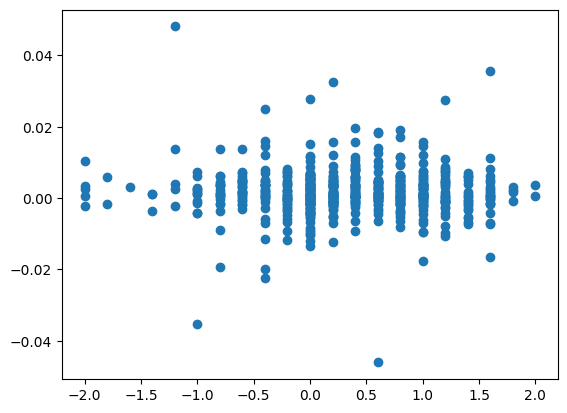

In [33]:
import matplotlib.pyplot as plt
plt.scatter(score, vals)